In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.autograd import Variable
from IPython.core.debugger import set_trace
import time

In [2]:
torch.manual_seed(0);

In [4]:
normalize = torchvision.transforms.Normalize((0.4895832, 0.4546405, 0.41594946), 
                                 (0.2520022, 0.24522494, 0.24728711))
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               normalize])

data = torchvision.datasets.ImageFolder(
                    root='./data/trainset/',
                    transform=transforms
                    )

test_data = torchvision.datasets.ImageFolder(
                    root= './data/test/', 
                    transform=transforms)

dataset_ratio = np.array([95, 5])/100

sizes = [int(x*len(data)) for x in dataset_ratio]
sizes[0] += len(data) - sum(sizes)

train_dataset, valid_dataset = torch.utils.data.random_split(dataset=data, lengths=sizes)

train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=128,
                    num_workers=2,
                    shuffle=True
                    )

valid_loader = torch.utils.data.DataLoader(
                    valid_dataset,
                    batch_size=128,
                    num_workers=2,
                    shuffle=True
                    )

test_loader = torch.utils.data.DataLoader(test_data)
classes = ('Cat', 'Dog')

In [17]:
def flaotTensorToImage(img, mean=0, std=1):
    """convert a tensor to an image"""
    img = np.transpose(img.numpy(), (1, 2, 0))
    img = (img*std+ mean)*255
    img = img.astype(np.uint8)    
    return img  

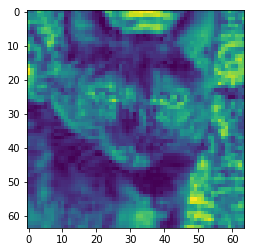

In [17]:
imgs, steering_angle = next(iter(train_loader))
im = imgs[0].numpy()[0]
plt.imshow(im)
# im2display = im.transpose((1,2,0))
# print(im2display.shape)
# plt.imshow(im2display, interpolation='nearest')
plt.show()

In [5]:
## get the mean and variance of our dataset for normalization

train = trainloader.__iter__().next()[0]
print (len(trainloader.dataset))
print('Mean: {}'.format(np.mean(train.numpy(), axis=(0, 2, 3))))
print('STD: {}'.format(np.std(train.numpy(), axis=(0, 2, 3))))

In [5]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [6]:
lr0 = 0.1
global lr 
lr = 0.1
optim = 'sgd'
num_epochs = 100
store_every = 200
best_acc = torch.FloatTensor([0])
start_epoch = 0
step = 10
gamma = 0.5

In [7]:
def dropout(p=None, dim=None, method='standard'):
    if method == 'standard':
        return nn.Dropout(p)
    elif method == 'gaussian':
        return GaussianDropout(p/(1-p))
    elif method == 'variational':
        return VariationalDropout(p/(1-p), dim)

In [8]:
class GaussianDropout(nn.Module):
    def __init__(self, alpha=1.0):
        super(GaussianDropout, self).__init__()
        self.alpha = torch.Tensor([alpha])
        
    def forward(self, x):
        """
        Sample noise   e ~ N(1, alpha)
        Multiply noise h = h_ * e
        """
        if self.train():
            # N(1, alpha)
            epsilon = torch.randn(x.size()) * self.alpha + 1

            epsilon = Variable(epsilon)
            if x.is_cuda:
                epsilon = epsilon.cuda()

            return x * epsilon
        else:
            return x

In [169]:
class XavierClassifier(nn.Module):
    def __init__(self):
        super(XavierClassifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=32,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            dropout(0.5, 32,'gaussian'),
            # Layer 2
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 3
            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
#             dropout(0.25, 128,'gaussian'),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 6
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
             # Layer 7
            nn.Conv2d(in_channels=256, out_channels=256,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 8
            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            # Layer 9
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            dropout(0.5, 512,'gaussian'),
            
        )
        self.net = nn.Linear(512, 512)
        self.net = nn.Linear(512, 2)
        self.init_weights()
    def forward(self, x):
        return self.net(self.conv(x).squeeze())
    
    def init_weights(self):
        for m in self.conv:
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        if type(self.net) == nn.Linear:
            nn.init.xavier_uniform_(self.net.weight)
            self.net.bias.data.fill_(0.01)

In [9]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv = nn.Sequential(
            # Layaer 1
            nn.Conv2d(in_channels=3, out_channels=64,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            dropout(0.25, 64,'gaussian'),

            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            
            # Layaer 3
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            
            # Layaer 5
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=(3,3) , padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            
             # Layaer 8
            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
        
            # Layaer 11
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            
            # Layaer 12
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            
            # Layaer 13
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),  
            dropout(0.5, 512,'gaussian'),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(2*2*512, 4096),
            nn.Linear(4096, 4096),
            nn.Linear(4096, 2),
        )
        self.init_weights()
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 2*2*512)
        x = self.classifier(x)
        return x
    def init_weights(self):
        for m in self.conv:
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        if type(self.classifier) == nn.Linear:
            nn.init.xavier_uniform_(self.classifier.weight)
            self.classifier.bias.data.fill_(0.01)

In [32]:
classifiers = ['ResidualClassifier', "VanilaCNN", "XavierClassifier", "VGG16" ]
my_classifier = 'VGG16'

if my_classifier=='ResidualClassifier':
    model = ResidualClassifier()
elif my_classifier=='VanilaCNN':
    model = VanilaCNN() 
elif my_classifier=='XavierClassifier':
    model = XavierClassifier() 
elif my_classifier=='VGG16':
    model = VGG16()
    
learning_rate = 0.01

if cuda_available:
    model = model.cuda()
if optim == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  momentum=0.95)
#     optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=0.01, momentum=0.95)
elif optim == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [11]:
start_time = time.time()

In [12]:
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
   GaussianDropout-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]         147,584
             ReLU-10          [-1, 128, 32, 32]               0
        MaxPool2d-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]         295,168
             ReLU-13          [-1, 256, 16, 16]               0
           Conv2d-14          [-1, 256,

In [87]:
def adjust_lr(optimizer, epoch, total_epochs, loss):
    mean_loss = np.mean(loss[epoch-2:-1])
    if np.float(loss[epoch]) < np.float(mean_loss):
        lr = lr0 * (0.5 ** (epoch+1 / float(total_epochs)))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [23]:
# Keep only a single checkpoint, the best over test accuracy.
def save_checkpoint(state, is_best, filename='./output/checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best == True:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [91]:
# class Trainer():
#     def __init__(self,  model, optimizer, criterion, train_loader, valid_loader):
#         super(Trainer, self).__init__()
#         self.model = model
#         self.optimizer = optimizer
#         self.criterion = criterion
#         self.train_loader = train_loader
#         self.valid_loader = valid_loader
        
#     def evaluate(self, dataset_loader, criterion):
#         LOSSES = 0
#         COUNTER = 0
#         for batch in dataset_loader:
#             optimizer.zero_grad()

#             x, y = batch
#     #             x = x.view(-1,1,28,28)
#             y = y.view(-1)
#             if cuda_available:
#                 x = x.cuda()
#                 y = y.cuda()

#             loss = criterion(model(x), y)
#             n = y.size(0)
#             LOSSES += loss.sum().data.cpu().numpy() * n
#             COUNTER += n

#         return LOSSES / float(COUNTER)
    
#     def accuracy(self, proba, y):
#         correct = torch.eq(proba.max(1)[1], y).sum().type(torch.FloatTensor)
#         return correct / y.size(0)
    
# #     def adjust_lr(self, optimizer, epoch, total_epochs):
# #         lr = lr0 * (0.5 ** (epoch / float(total_epochs)))
# #         for param_group in optimizer.param_groups:
# #             param_group['lr'] = lr
    
#     def train_model(self):
#         c = 0
#         LOSSES = 0
#         lv = 0
#         av = 0
#         loss_val = []
#         COUNTER = 0
#         ITERATIONS = 0
#         learning_curve_nll_train = list()
#         learning_curve_nll_test = list()
#         learning_curve_acc_train = list()
#         learning_curve_acc_test = list()
#         for e in range(num_epochs):    
#             for batch in train_loader:
#                 optimizer.zero_grad()
#                 x, y = batch
#     #             x = x.view(-1,1,28,28)
#                 y = y.view(-1)
#                 if cuda_available:
#                     x = x.cuda()
#                     y = y.cuda()
#                 loss = criterion(model(x), y)
#                 loss.backward()
#                 optimizer.step()

#                 n = y.size(0)
#                 LOSSES += loss.sum().data.cpu().numpy() * n
#                 COUNTER += n
#                 ITERATIONS += 1
#                 if ITERATIONS%(store_every/5) == 0:
#                     avg_loss = LOSSES / float(COUNTER)
#                     LOSSES = 0
#                     COUNTER = 0
#                     print(" Iteration {}: TRAIN {:.4f}".format(
#                         ITERATIONS, avg_loss))# transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


#                 if ITERATIONS%(store_every) == 0:     

#                     train_loss = self.evaluate(train_loader, criterion)
#                     learning_curve_nll_train.append(train_loss)
#                     test_loss = self.evaluate(valid_loader, criterion)
#                     learning_curve_nll_test.append(test_loss)

#                     train_acc = self.evaluate(train_loader, self.accuracy)
#                     learning_curve_acc_train.append(train_acc)
#                     test_acc = self.evaluate(valid_loader, self.accuracy)
#                     learning_curve_acc_test.append(test_acc)

#                     print(" [Loss] TRAIN {:.4f} / TEST {:.4f}".format(
#                         train_loss, test_loss))
#                     print(" [ACC] TRAIN {:.4f} / TEST {:.4f}".format(
#                         train_acc, test_acc))
#                     lv = test_loss
#                     av = test_acc
                    
#                     print('=> Validation set: Accuracy: {:.4f}'.format(av))
#                     acc = torch.FloatTensor([av])
#                     is_best = bool(acc.numpy() > best_acc.numpy())
#                     best_accuracy = torch.FloatTensor(max(acc.numpy(), best_acc.numpy()))
#                     # Save checkpoint if is a new best
#                     save_checkpoint({
#                         'epoch': start_epoch + e + 1,
#                         'state_dict': model.state_dict(),
#                         'best_accuracy': best_accuracy
#                     }, is_best)  
                   
#             loss_val.append(lv)
# #             self.adjust_lr(optimizer, e+1, num_epochs)
#             c += 1    
#             if (c%10 == 0):
#                 adjust_lr(optimizer, e, num_epochs, loss_val)

#         return learning_curve_nll_train, \
#                learning_curve_nll_test, \
#                learning_curve_acc_train, \
#                learning_curve_acc_test, 
    
# trainer = Trainer(model, optimizer, criterion, train_loader, valid_loader)
# nll_train, nll_test, acc_train, acc_test =  trainer.train_model()
# print('Done...')

 Iteration 40: TRAIN 0.6926
 Iteration 80: TRAIN 0.6889
 Iteration 120: TRAIN 0.6866
 Iteration 160: TRAIN 0.6791
 Iteration 200: TRAIN 0.6742
 [Loss] TRAIN 0.6519 / TEST 0.6589
 [ACC] TRAIN 0.6317 / TEST 0.6226
=> Validation set: Accuracy: 0.6226
=> Saving a new best
 Iteration 240: TRAIN 0.6535
 Iteration 280: TRAIN 0.6395
 Iteration 320: TRAIN 0.6299
 Iteration 360: TRAIN 0.6212
 Iteration 400: TRAIN 0.6159
 [Loss] TRAIN 0.6031 / TEST 0.6203
 [ACC] TRAIN 0.6819 / TEST 0.6547
=> Validation set: Accuracy: 0.6547
=> Saving a new best
 Iteration 440: TRAIN 0.6118
 Iteration 480: TRAIN 0.5889
 Iteration 520: TRAIN 0.5965
 Iteration 560: TRAIN 0.5832
 Iteration 600: TRAIN 0.5821
 [Loss] TRAIN 0.5455 / TEST 0.5684
 [ACC] TRAIN 0.7241 / TEST 0.6977
=> Validation set: Accuracy: 0.6977
=> Saving a new best
 Iteration 640: TRAIN 0.5678
 Iteration 680: TRAIN 0.5647
 Iteration 720: TRAIN 0.5505
 Iteration 760: TRAIN 0.5412
 Iteration 800: TRAIN 0.5414
 [Loss] TRAIN 0.5226 / TEST 0.5481
 [ACC] TR

 Iteration 6040: TRAIN 0.3010
 Iteration 6080: TRAIN 0.3089
 Iteration 6120: TRAIN 0.3085
 Iteration 6160: TRAIN 0.3110
 Iteration 6200: TRAIN 0.3120
 [Loss] TRAIN 0.3065 / TEST 0.4883
 [ACC] TRAIN 0.8728 / TEST 0.7698
=> Validation set: Accuracy: 0.7698
=> Saving a new best
 Iteration 6240: TRAIN 0.3065
 Iteration 6280: TRAIN 0.3110
 Iteration 6320: TRAIN 0.3053
 Iteration 6360: TRAIN 0.3082
 Iteration 6400: TRAIN 0.3171
 [Loss] TRAIN 0.3079 / TEST 0.4916
 [ACC] TRAIN 0.8760 / TEST 0.7808
=> Validation set: Accuracy: 0.7808
=> Saving a new best
 Iteration 6440: TRAIN 0.3038
 Iteration 6480: TRAIN 0.3128
 Iteration 6520: TRAIN 0.3119
 Iteration 6560: TRAIN 0.2954
 Iteration 6600: TRAIN 0.3087
 [Loss] TRAIN 0.3064 / TEST 0.4988
 [ACC] TRAIN 0.8735 / TEST 0.7708
=> Validation set: Accuracy: 0.7708
=> Saving a new best
 Iteration 6640: TRAIN 0.3007
 Iteration 6680: TRAIN 0.3123
 Iteration 6720: TRAIN 0.3099
 Iteration 6760: TRAIN 0.3082
 Iteration 6800: TRAIN 0.3172
 [Loss] TRAIN 0.3081 /

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: 

In [13]:
def adjust_learning_rate(optimizer, epoch, lr):
    if (epoch+1) % step == 0:
        lr *= gamma
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [33]:
def save_checkpoint(state, best, file_path="./output/checkpoint.pth.tar"):
    if best:
        print('new checkpoint is saved!')
        torch.save(state, file_path)
    else:
        print ('no improvement!')

In [34]:
class Trainer():
    def __init__(self,  model, optimizer, criterion, train_loader, valid_loader):
        super(Trainer, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        
    def evaluate(self, dataset_loader, criterion):
        LOSSES = 0
        COUNTER = 0
        for batch in dataset_loader:
            optimizer.zero_grad()

            x, y = batch
            y = y.view(-1)
            if cuda_available:
                x = x.cuda()
                y = y.cuda()

            loss = criterion(model(x), y)
            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n
            COUNTER += n

        return LOSSES / float(COUNTER)
    
    def accuracy(self, proba, y):
        correct = torch.eq(proba.max(1)[1], y).sum().type(torch.FloatTensor)
        return correct / y.size(0)

    def train_model(self):
        best_acc = torch.FloatTensor([0])
        c = 0
        LOSSES = 0
        loss_val = []
        COUNTER = 0
        ITERATIONS = 0
        learning_curve_nll_train = list()
        learning_curve_nll_test = list()
        learning_curve_acc_train = list()
        learning_curve_acc_test = list()
        for e in range(num_epochs):
#             adjust_learning_rate(optimizer, e, lr)
            for batch in train_loader:
                optimizer.zero_grad()
                x, y = batch
                y = y.view(-1)
                if cuda_available:
                    x = x.cuda()
                    y = y.cuda()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()

                n = y.size(0)
                LOSSES += loss.sum().data.cpu().numpy() * n
                COUNTER += n
                ITERATIONS += 1
                if ITERATIONS%(store_every/5) == 0:
                    avg_loss = LOSSES / float(COUNTER)
                    LOSSES = 0
                    COUNTER = 0
                    print(" Iteration {}: TRAIN {:.4f}".format(
                        ITERATIONS, avg_loss))

            train_loss = self.evaluate(train_loader, criterion)
            learning_curve_nll_train.append(train_loss)
            test_loss = self.evaluate(valid_loader, criterion)
            learning_curve_nll_test.append(test_loss)

            train_acc = self.evaluate(train_loader, self.accuracy)
            learning_curve_acc_train.append(train_acc)
            test_acc = self.evaluate(valid_loader, self.accuracy)
            learning_curve_acc_test.append(test_acc)

            print(" [Loss] TRAIN {:.4f} / TEST {:.4f}".format(
                train_loss, test_loss))
            print(" [ACC] TRAIN {:.4f} / TEST {:.4f}".format(
                train_acc, test_acc))


            acc = torch.FloatTensor([test_acc])
            is_best = (acc.numpy() > best_acc.numpy())
            best_acc = torch.FloatTensor(max(acc.numpy(), best_acc.numpy()))
            # Save checkpoint if is a new best
            save_checkpoint({
                'epoch': start_epoch + e + 1,
                'state_dict': model.state_dict(),
                'best_accuracy': best_acc
            }, is_best)  
                   
#             loss_val.append(test_loss)
#             c += 1    
#             if (c%10 == 0):
#                 adjust_lr(optimizer, e, num_epochs, loss_val)

        return learning_curve_nll_train, \
               learning_curve_nll_test, \
               learning_curve_acc_train, \
               learning_curve_acc_test, 

In [ ]:
trainer = Trainer(model, optimizer, criterion, train_loader, valid_loader)
nll_train, nll_test, acc_train, acc_test =  trainer.train_model()
print('Done...')

 Iteration 40: TRAIN 0.6936
 Iteration 80: TRAIN 0.6942
 Iteration 120: TRAIN 0.6929
 [Loss] TRAIN 0.6936 / TEST 0.6922
 [ACC] TRAIN 0.4991 / TEST 0.5175
new checkpoint is saved!
 Iteration 160: TRAIN 0.6930
 Iteration 200: TRAIN 0.6925
 Iteration 240: TRAIN 0.6911
 Iteration 280: TRAIN 0.6855
 [Loss] TRAIN 0.6833 / TEST 0.6820
 [ACC] TRAIN 0.5451 / TEST 0.5516
new checkpoint is saved!
 Iteration 320: TRAIN 0.6784
 Iteration 360: TRAIN 0.6642
 Iteration 400: TRAIN 0.6698
 Iteration 440: TRAIN 0.6724
 [Loss] TRAIN 0.6569 / TEST 0.6604
 [ACC] TRAIN 0.6272 / TEST 0.6196
new checkpoint is saved!
 Iteration 480: TRAIN 0.6511
 Iteration 520: TRAIN 0.6272
 Iteration 560: TRAIN 0.6041
 [Loss] TRAIN 0.5774 / TEST 0.5710
 [ACC] TRAIN 0.7007 / TEST 0.7097
new checkpoint is saved!
 Iteration 600: TRAIN 0.6270
 Iteration 640: TRAIN 0.5902
 Iteration 680: TRAIN 0.5725
 Iteration 720: TRAIN 0.5600
 [Loss] TRAIN 0.5558 / TEST 0.5481
 [ACC] TRAIN 0.7268 / TEST 0.7277
new checkpoint is saved!
 Iteration

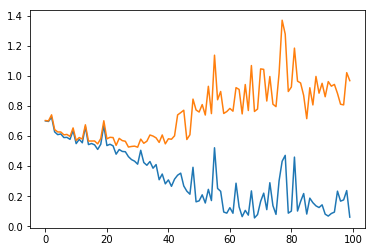

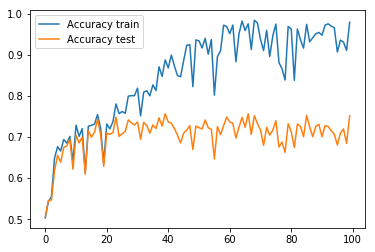

In [165]:
plt.figure(1)
plt.plot(range(len(nll_train)), nll_train, label="Loss train" )
plt.plot(range(len(nll_test)), nll_test,   label="Loss test" )
plt.figure(2)
plt.plot(range(len(acc_train)), acc_train, label="Accuracy train" )
plt.plot(range(len(acc_test)), acc_test,   label="Accuracy test" )
plt.legend()
plt.show()

In [ ]:
class DriveData(Dataset):
    __xs = []
    __ys = []
    normalize = transforms.Normalize((0.4895832, 0.4546405, 0.41594946), 
                                 (0.2520022, 0.24522494, 0.24728711))
    transform = transforms.Compose([transforms.ToTensor(), normalize])

    def __init__(self, folder_dataset, transform=None):
        self.transform = transform
        # Open and load text file including the whole training data
        
        for i in range(1,5000):
            address = folder_dataset + (str(i)+".jpg")
            self.__xs.append(address)

    # Override to give PyTorch access to any image on the dataset
    def __getitem__(self, index):
        img = Image.open(self.__xs[index])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        # Convert image and label to torch tensors
        img = np.transpose(np.asarray(img), (2, 0, 1))
        img = torch.from_numpy(np.asarray(img))
        
        return img, 0

    # Override to give PyTorch size of dataset
    def __len__(self):
        return len(self.__xs)

In [ ]:
dset_train = DriveData("./Data/testset/test/")
test_loader2 = DataLoader(dset_train)

In [ ]:
results = [[]]
for batch_idx, (inputs, targets) in enumerate(test_loader2):
    if cuda_available:
        inputs, targets = inputs.cuda(), targets.cuda()
    inputs= inputs.type(torch.cuda.FloatTensor)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    results = np.append(results, predicted.cpu().numpy())

results = np.int8(results)

In [25]:
results = [[]]
for batch_idx, (inputs, targets) in enumerate(test_loader):
    if cuda_available:
        inputs, targets = inputs.cuda(), targets.cuda()
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    results = np.append(results, predicted.cpu().numpy())

results = np.int8(results)

In [49]:
df = pd.DataFrame({ 'id': range(1, len(results)+1),
                    'label': results})
df['label'].replace([0,1], ['Cat','Dog'], inplace=True)
df[df.columns].to_csv('submisstion.csv',index=False)
print('Done...')

Done...
